In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
customers = pd.read_csv('Customers.csv', parse_dates=['SignupDate'])
transactions = pd.read_csv('Transactions.csv', parse_dates=['TransactionDate'])

In [21]:
latest_date = transactions['TransactionDate'].max()
rfm = transactions.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (latest_date - x.max()).days),
    Frequency=('TransactionID', 'count'),
    Monetary=('TotalValue', 'sum')
).reset_index()

In [22]:
all_customers = customers[['CustomerID']]
rfm_full = all_customers.merge(rfm, on='CustomerID', how='left')

In [23]:
rfm_full['Recency'] = rfm_full['Recency'].fillna((latest_date - customers['SignupDate']).dt.days)
rfm_full['Frequency'] = rfm_full['Frequency'].fillna(0)
rfm_full['Monetary'] = rfm_full['Monetary'].fillna(0)

In [24]:
rfm_full = rfm_full.merge(customers[['CustomerID', 'SignupDate']], on='CustomerID', how='left')
rfm_full['LastTransactionDate'] = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()['TransactionDate']
rfm_full['LastTransactionDate'] = rfm_full['LastTransactionDate'].fillna(latest_date)
rfm_full['Tenure'] = (rfm_full['LastTransactionDate'] - rfm_full['SignupDate']).dt.days
rfm_full['Tenure'] = np.where(rfm_full['Tenure'] < 0, 0, rfm_full['Tenure'])
rfm_full.drop(['SignupDate', 'LastTransactionDate'], axis=1, inplace=True)

In [25]:
customers_regions = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'])
data = rfm_full.merge(customers_regions, on='CustomerID', how='left')

In [26]:
numerical_features = ['Recency', 'Frequency', 'Monetary', 'Tenure']
categorical_features = [col for col in data.columns if col.startswith('Region_')]

In [27]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numerical_features])
data_scaled = pd.DataFrame(data_scaled, columns=numerical_features)
data_final = pd.concat([data_scaled, data[categorical_features]], axis=1)

In [28]:
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_final)
    db_scores.append(davies_bouldin_score(data_final, labels))

optimal_k = np.argmin(db_scores) + 2 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [29]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(data_final)
data['Cluster'] = labels

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [30]:
db_index = davies_bouldin_score(data_final, labels)
silhouette_avg = silhouette_score(data_final, labels)

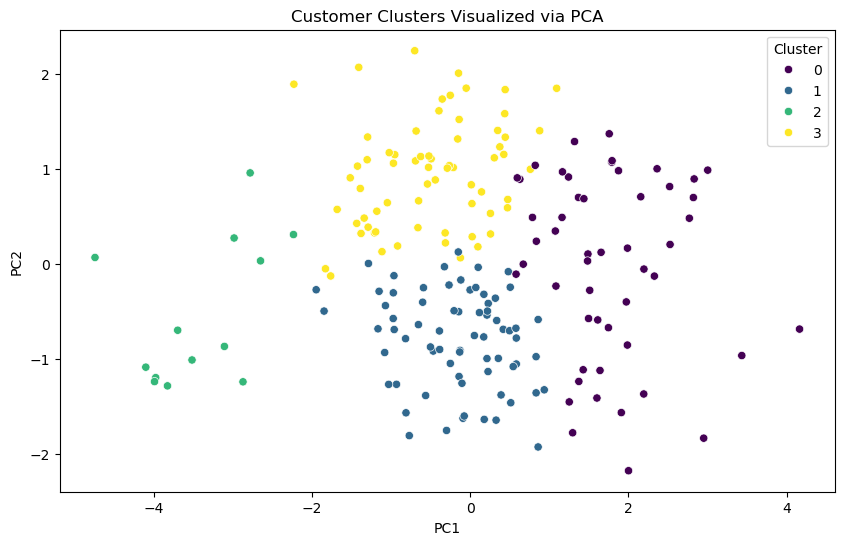

In [31]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_final)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Customer Clusters Visualized via PCA')
plt.savefig('clusters_pca.png')
plt.show()

In [32]:
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")

Optimal number of clusters: 4
Davies-Bouldin Index: 1.312
Silhouette Score: 0.234
